# IBM Capstone Project: The Battle of the Neighborhoods

## Which Boston's neghborhood is ideal for openning a Gastrobar?

### Introduction

In this project, I'm going to determine which Boston's neighborhood is a good place for opening a Gastrobar.
<ul>
    <li>I'll scrap the data about Boston's neighborhoods from wikipedia https://en.wikipedia.org/wiki/Neighborhoods_in_Boston</li>
    <li>I'll convert neighborhoods data into their equivalent latitude and longitude values.</li>
    <li>I'll use the Foursquare API to explore Boston's neighborhoods and will get venues.</li>
    <li>I'll use the Foursquare API to get venue ratings and likes.</li>
    <li>I'll use the Folium library to visualize the neighborhoods, venues , clusters</li>
    <li>I'll use the k-means clustering and Agglomerative algorithms to complete clustering task</li>
</ul>

##  1. Download and Explore Neigborhood Dataset

### Import Libraries

In [1]:
!pip install geopy    
!pip install folium   
!pip install geocoder

     |████████████████████████████████| 102kB 8.7MB/s ta 0:00:011
     |████████████████████████████████| 102kB 7.0MB/s ta 0:00:011


In [2]:

#importing libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [3]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt # for graphical usage 
from folium.plugins import HeatMap

### Get Boston's neighborhood data

In [4]:
page = requests.get("https://en.wikipedia.org/wiki/Neighborhoods_in_Boston")

#getting page content with BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')

neigborhoods = soup.find_all("div", class_='div-col columns column-width')

for tag in neigborhoods:
 nb="{0}: {1}".format(tag.name, tag.text)

nb_list = []
for b in neigborhoods[0:]:
    result = b.text.strip()
    nb_list.append(result)
nb_list=[sub.replace('\n', ',') for sub in nb_list] 
nb_list
for element in nb_list:
    boston_neighborhoods = element.split(',')


#list cleanup   
boston_neighborhoods = [sub.replace(' (divided for planning purposes into Mid Dorchester and Dorchester)', '') for sub in boston_neighborhoods]
boston_neighborhoods = [sub.replace(' (includes Longwood)', '') for sub in boston_neighborhoods]

#convert the list into data frame
df = pd.DataFrame(boston_neighborhoods,columns =['Neighborhoods'])

df.drop(df.index[6],inplace=True)
df=df.reset_index()
df

,index,Neighborhoods
0,0,Allston
1,1,Back Bay
2,2,Bay Village
3,3,Beacon Hill
4,4,Brighton
5,5,Charlestown
6,7,Dorchester
7,8,Downtown
8,9,East Boston
9,10,Fenway Kenmore


### Get neighborhood's latitude and longitude

In [40]:
nbl = []
for i in range(len(df)) : 
    nbh=df.loc[i, "Neighborhoods"]
    address = nbh+', Boston, MA'
    geolocator = Nominatim(user_agent="boston_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    nbl.append((nbh,latitude,longitude))
    print('The geograpical coordinate of '+nbh+' are {}, {}.'.format(latitude, longitude))

cols=['Neighborhoods','Latitude','Longitude']
blat=42.3601
blong=71.0589
dfr = pd.DataFrame(nbl, columns=cols)


The geograpical coordinate of Allston are 42.3554344, -71.1321271.
The geograpical coordinate of Back Bay are 42.3507067, -71.0797297.
The geograpical coordinate of Bay Village are 42.35001105, -71.0669477958571.
The geograpical coordinate of Beacon Hill are 42.3587085, -71.067829.
The geograpical coordinate of Brighton are 42.3500971, -71.1564423.
The geograpical coordinate of Charlestown are 42.3778749, -71.0619957.
The geograpical coordinate of Dorchester are 42.2973205, -71.0744952.
The geograpical coordinate of Downtown are 52.971148799999995, -0.059809371175602276.
The geograpical coordinate of East Boston are 42.3750973, -71.0392173.
The geograpical coordinate of Fenway Kenmore are 42.34422445, -71.09444515776886.
The geograpical coordinate of Hyde Park are 42.2556543, -71.1244963.
The geograpical coordinate of Jamaica Plain are 42.3098201, -71.1203299.
The geograpical coordinate of Mattapan are 42.2675657, -71.0924273.
The geograpical coordinate of Mission Hill are 42.33255965,

###  Plot the neighborhoods on the map

In [48]:

map_boston = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(dfr['Latitude'], dfr['Longitude'], dfr['Neighborhoods']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)  
    
map_boston

# 2. Loading Venues and Analyzing Neighborhoods

### Exploring The Venues with Foursquare API 

In [49]:
CLIENT_ID = 'FMHYIBNYOEAFMMFRZOG2WW4YRFI5EOOC5IXCYZDGJVRU03MB' # your Foursquare ID
CLIENT_SECRET = 'KHCM4VORWGIQ4POF2WEUUJRHOVHDPEDTRGJGZDOJN3RQPWEI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [52]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (dfr['Latitude'], dfr['Longitude'], dfr['Neighborhoods'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 231 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Allston,42.355434,-71.132127,Lulu's Allston,530647fd498e4ac184afea7c,42.355068,-71.134107,167,Comfort Food Restaurant
1,Allston,42.355434,-71.132127,Azama Grill,4b7b78f1f964a520d1642fe3,42.354422,-71.132358,114,Falafel Restaurant
2,Allston,42.355434,-71.132127,Fish Market Sushi Bar,4b758e61f964a520e7132ee3,42.353039,-71.132975,275,Sushi Restaurant
3,Allston,42.355434,-71.132127,BonChon Chicken,4d0027192685a35dd345c790,42.353105,-71.130921,277,Fried Chicken Joint
4,Allston,42.355434,-71.132127,Mala Restaurant,5599b403498e4220e1753509,42.352960,-71.131033,289,Chinese Restaurant


In [53]:

print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Pizza Place,57
Park,42
Italian Restaurant,38
Coffee Shop,37
Donut Shop,32
American Restaurant,28
Sandwich Place,27
Bakery,25
Café,23


### Filter venues to show restaurants only

In [54]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place','Falafel Restaurant','Comfort Food Restaurant', 'Gastropub', 'Restaurant']
gastropub_list = ['Gastropub']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
gastropubs = neighborhood_restaurants[neighborhood_restaurants['VenueCategory'].isin(gastropub_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(gastropub_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of gastropubs:', len(gastropubs['VenueId'].unique()))
print('Percentage of gastropubs: {:.2f}%'.format(len(gastropubs['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))

Total number of restaurants: 348
Total number of gastropubs: 10
Percentage of gastropubs: 2.87%


Filter restaurants out of all venues

12 neighborhoods do not have any Gastropubs


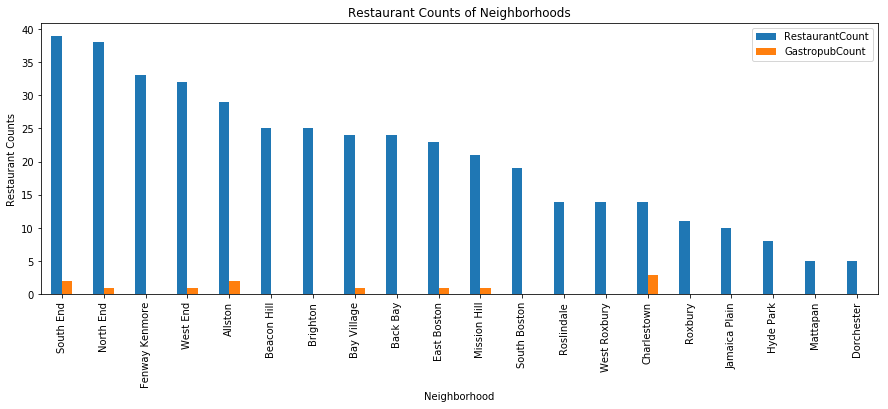

In [55]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of Turkish restaurants in each Neighborhood
df_gastropub_counts =  gastropubs.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "GastropubCount"})[['GastropubCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(gastropubs['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_gastropub_counts = df_gastropub_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'GastropubCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_gastropub_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_gastropub_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Gastropubs'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['RestaurantCount','GastropubCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

### Get the restaurant's overall rating

In [56]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()

,VenueId,VenueRating,VenueLikes
0,530647fd498e4ac184afea7c,8.8,198.0
1,4b7b78f1f964a520d1642fe3,8.4,20.0
2,4b758e61f964a520e7132ee3,8.7,56.0
3,4d0027192685a35dd345c790,8.6,229.0
4,5599b403498e4220e1753509,8.5,21.0


In [57]:
restaurants_raitings.to_csv('restaurants_raitings.csv')
#merge raitings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Allston,42.355434,-71.132127,Lulu's Allston,530647fd498e4ac184afea7c,42.355068,-71.134107,167,Comfort Food Restaurant,8.8,198.0
1,Allston,42.355434,-71.132127,Azama Grill,4b7b78f1f964a520d1642fe3,42.354422,-71.132358,114,Falafel Restaurant,8.4,20.0
2,Allston,42.355434,-71.132127,Fish Market Sushi Bar,4b758e61f964a520e7132ee3,42.353039,-71.132975,275,Sushi Restaurant,8.7,56.0
3,Allston,42.355434,-71.132127,BonChon Chicken,4d0027192685a35dd345c790,42.353105,-71.130921,277,Fried Chicken Joint,8.6,229.0
4,Allston,42.355434,-71.132127,Mala Restaurant,5599b403498e4220e1753509,42.352960,-71.131033,289,Chinese Restaurant,8.5,21.0


In [58]:
gastropubs = gastropubs.merge(restaurants_raitings)
gastropubs#=gastropubs#.fillna(0)


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Allston,42.355434,-71.132127,Deep Ellum,49ce55f6f964a520335a1fe3,42.353844,-71.136923,432,Gastropub,8.7,409.0
1,Allston,42.355434,-71.132127,The Glenville Stops,53309e44498e3c6c34953cc8,42.349514,-71.135033,701,Gastropub,8.5,37.0
2,Bay Village,42.350011,-71.066948,The Butcher Shop,49cf773ef964a520aa5a1fe3,42.344033,-71.071539,765,Gastropub,9.0,132.0
3,South End,42.341310,-71.077230,The Butcher Shop,49cf773ef964a520aa5a1fe3,42.344033,-71.071539,557,Gastropub,9.0,132.0
4,Charlestown,42.377875,-71.061996,Monument Restaurant & Tavern,586d78f9de0cbc0b7f87e131,42.376865,-71.066053,352,Gastropub,8.8,41.0
5,Charlestown,42.377875,-71.061996,Brewer's Fork,54ebdb95498e4a516b5f74f3,42.376729,-71.056573,463,Gastropub,9.3,141.0
6,Charlestown,42.377875,-71.061996,Blackmoor Bar and Kitchen,5731eb0c498ee1b150baad37,42.371211,-71.061583,742,Gastropub,7.7,40.0
7,East Boston,42.375097,-71.039217,Cunard Tavern,5955758adec1d63ee666589e,42.367273,-71.038733,871,Gastropub,8.3,20.0
8,Mission Hill,42.332560,-71.103608,The Squealing Pig,41a27d80f964a520411e1fe3,42.334879,-71.102101,286,Gastropub,7.6,97.0
9,North End,42.365097,-71.054495,Ward 8,529d0b3911d2e1c994c39b59,42.365475,-71.058492,331,Gastropub,8.0,167.0


### Show restaurants on heat map


In [72]:
boston = [dfr.loc[19,"Latitude"], dfr.loc[19,"Longitude"]]
map_restaurant= folium.Map(location=boston, zoom_start=12)
df_neighborhood_nogastropubs = dfr[dfr['Neighborhoods'].isin(noRestList)]
locations = neighborhood_restaurants[['VenueLatitude','VenueLongitude']]
locationlist = locations.values.tolist() 
locationlist = [[float(lat),float(lon)] for [lat,lon] in locationlist] 
folium.TileLayer('cartodbpositron').add_to(map_boston) 
HeatMap(locationlist).add_to(map_restaurant)
folium.Marker(boston).add_to(map_boston)
folium.Circle(boston, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(boston, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(boston, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(boston, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(gastropubs['VenueLatitude'], gastropubs['VenueLongitude'], gastropubs['Neighborhood'], gastropubs['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = gastropubs[gastropubs['VenueRating'] <10]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
map_restaurant

### Neighborhoods with no gastropubs

In [73]:
#boston = [latitude, longitude]
map_restaurant= folium.Map(location=boston, zoom_start=12)

df_neighborhood_nogastropubs = dfr[dfr['Neighborhoods'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_boston) 
HeatMap(locationlist).add_to(map_restaurant)
folium.Marker(boston).add_to(map_boston)
folium.Circle(boston, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(boston, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(boston, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(boston, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_nogastropubs['Latitude'], df_neighborhood_nogastropubs['Longitude'], df_neighborhood_nogastropubs['Neighborhoods']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant


# 3. Cluster Neigborhoods using Agglomerative Clustering

In [74]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()
# move neighborhood column to the first column and filter only restaurant columns 
#fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
#venues_grouped = venues_grouped[fixed_columns]

#print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))

venues_grouped



,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Allston,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
1,Back Bay,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,1,3,0,0,1
2,Bay Village,0,0,0,2,0,0,0,0,1,...,0,0,0,0,0,1,3,0,0,0
3,Beacon Hill,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Brighton,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0
5,Charlestown,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,Dorchester,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
7,East Boston,0,0,0,0,0,0,2,0,0,...,0,0,0,1,1,0,0,0,0,0
8,Fenway Kenmore,0,0,0,6,0,0,1,2,0,...,0,0,0,2,0,1,1,0,0,0
9,Hyde Park,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [75]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [76]:
num_top_venues = 10

columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Place'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Place'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most#.head()


,Neighborhood,Total Number of Venues,1st Most Common Place,2nd Most Common Place,3rd Most Common Place,4th Most Common Place,5th Most Common Place,6th Most Common Place,7th Most Common Place,8th Most Common Place,9th Most Common Place,10th Most Common Place
0,Allston,62,Pizza Place,Korean Restaurant,Liquor Store,Fried Chicken Joint,Rock Club,Bakery,Gastropub,Thai Restaurant,Hockey Rink,Furniture / Home Store
1,Back Bay,100,Seafood Restaurant,Spa,Clothing Store,Coffee Shop,Ice Cream Shop,Italian Restaurant,Bakery,Park,Dessert Shop,Plaza
2,Bay Village,100,Spa,Coffee Shop,Theater,Gym,Asian Restaurant,Wine Shop,Italian Restaurant,French Restaurant,Dessert Shop,Park
3,Beacon Hill,100,Italian Restaurant,Hotel,Steakhouse,Bakery,Pizza Place,Historic Site,Park,French Restaurant,Coffee Shop,Scenic Lookout
4,Brighton,76,Pizza Place,Chinese Restaurant,Coffee Shop,Grocery Store,Café,Bakery,Donut Shop,Pub,Sushi Restaurant,Convenience Store
5,Charlestown,63,Park,Café,Donut Shop,Pizza Place,History Museum,Gastropub,Coffee Shop,Pub,Grocery Store,Convenience Store
6,Dorchester,20,Yoga Studio,Gym,Southern / Soul Food Restaurant,Fast Food Restaurant,Fried Chicken Joint,Shoe Store,Market,Donut Shop,Liquor Store,Park
7,East Boston,44,Mexican Restaurant,Park,Italian Restaurant,Pizza Place,Seafood Restaurant,Art Gallery,Café,Latin American Restaurant,Sandwich Place,Community Center
8,Fenway Kenmore,100,American Restaurant,Hotel,Lounge,Burger Joint,Café,Concert Hall,Middle Eastern Restaurant,Donut Shop,Bakery,Sushi Restaurant
9,Hyde Park,35,Pizza Place,Business Service,American Restaurant,Home Service,Grocery Store,Donut Shop,Pharmacy,Park,Yoga Studio,Storage Facility


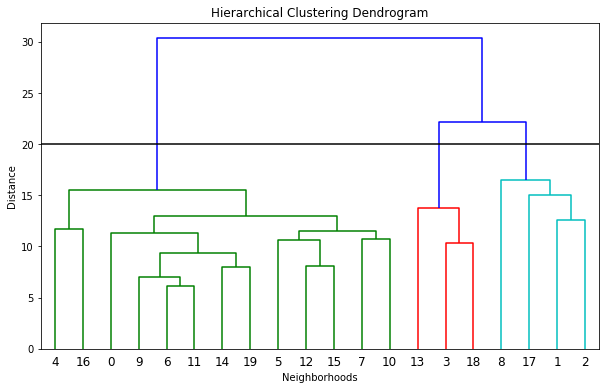

In [77]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [78]:
from sklearn.cluster import AgglomerativeClustering
kclusters= 10
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)
dfr.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
venues_grouped['NeighborhoodCluster'] = clusterresult
venues_cluster= dfr.merge(venues_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighborhood','1st Most Common Place','2nd Most Common Place','3rd Most Common Place']])
venues_cluster.head()

,Neighborhood,Latitude,Longitude,NeighborhoodCluster,1st Most Common Place,2nd Most Common Place,3rd Most Common Place
0,Allston,42.355434,-71.132127,1,Pizza Place,Korean Restaurant,Liquor Store
1,Back Bay,42.350707,-71.079730,8,Seafood Restaurant,Spa,Clothing Store
2,Bay Village,42.350011,-71.066948,7,Spa,Coffee Shop,Theater
3,Beacon Hill,42.358708,-71.067829,4,Italian Restaurant,Hotel,Steakhouse
4,Brighton,42.350097,-71.156442,9,Pizza Place,Chinese Restaurant,Coffee Shop


In [79]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster  in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(boston).add_to(map_clusters)
folium.Circle(boston, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(boston, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(boston, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(boston, radius=10000, fill=False, color='black').add_to(map_clusters)         
map_clusters

In [80]:

print(venues_cluster.groupby(['NeighborhoodCluster','1st Most Common Place' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['NeighborhoodCluster','2nd Most Common Place' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

                                           Neighborhood Count
NeighborhoodCluster 1st Most Common Place                    
0                   Donut Shop                              2
                    Mexican Restaurant                      1
                    Park                                    2
1                   Convenience Store                       1
                    Pizza Place                             4
                    Yoga Studio                             1
2                   Italian Restaurant                      1
3                   American Restaurant                     1
4                   Italian Restaurant                      2
5                   Pizza Place                             1
6                   Italian Restaurant                      1
7                   Spa                                     1
8                   Seafood Restaurant                      1
9                   Pizza Place                             1


Neighborhood Count
NeighborhoodCluster 2nd Most Common Place                    
0                   Bakery                                  1
                    Café                                    1
                    Park                                    2
                    Pizza Place                             1
1                   American Restaurant                     1
                    Business Service                        1
                    Gym                                     1
                    Korean Restaurant                       1
                    Pharmacy                                1
                    Pizza Place                             1
2                   American Restaurant                     1
3                   Hotel                                   1
4                   Hotel                                   2
5                   Bar                                     1
6                   Seafood Restaurant                      1
7                   Coffee Shop                             1
8                   Spa                                     1
9                   Chinese Restaurant                      1